In [834]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_regression

# Library data visualization
import plotly
import matplotlib.pylab as pl
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot as plt
from IPython.display import SVG

from scipy import stats

In [835]:
file_path = "/kaggle/input/predicta-1-0-predict-the-unpredictable-part-2/daily_data.csv" 
df = pd.read_csv(file_path)

In [836]:
test_file_path = "/kaggle/input/predicta-1-0-predict-the-unpredictable-part-2/submission.csv"
Submission = pd.read_csv(test_file_path)

# Data Understanding and Preprocessing

In [837]:
df

,day_id,city_id,temperature_celsius,condition_text,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,sunrise,sunset
0,D0001,C001,27.0,NaN,6.1,210,1006.0,0.0,54,75,28.0,10.0,6.0,11.9,2,06:04 AM,07:19 PM
1,D0002,C001,22.0,NaN,6.1,170,1006.0,0.0,73,75,24.5,10.0,1.0,23.4,1,06:05 AM,07:18 PM
2,D0003,C001,20.0,Light Rain with Thunder,3.6,10,1011.0,4.5,100,75,20.0,10.0,1.0,12.6,1,06:05 AM,07:18 PM
3,D0004,C001,17.0,Clear and Sunny,6.1,150,1018.0,0.0,88,0,17.0,10.0,1.0,11.2,1,06:06 AM,07:16 PM
4,D0005,C001,18.0,NaN,3.6,92,1019.0,0.0,94,0,18.0,10.0,1.0,9.0,1,06:07 AM,07:15 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888,D2889,C112,17.1,Clear and Sunny,13.3,61,1017.0,0.0,57,3,17.1,10.0,1.0,22.2,1,05:49 AM,05:51 PM
2889,D2890,C112,17.4,NaN,13.0,51,1017.0,0.0,49,0,17.4,10.0,1.0,22.2,1,05:49 AM,05:52 PM
2890,D2891,C112,19.2,NaN,11.5,46,1016.0,0.0,34,0,19.2,10.0,1.0,21.3,2,05:48 AM,05:52 PM
2891,D2892,C112,19.2,NaN,14.4,76,1017.0,0.0,45,2,19.2,10.0,1.0,24.9,2,05:47 AM,05:52 PM


In [838]:
cols = list(df.columns)
cols.append(cols.pop(cols.index('condition_text')))
df = df[cols]

In [839]:
#Function to Explor data details
def customDescription(df: pd.DataFrame, numeric_only: bool = False):
    if numeric_only:
        df = df.select_dtypes(include=np.number)
    
    desc = pd.DataFrame(index=df.columns.to_list())
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['null'] = df.isnull().sum()
    
    # Handle numeric columns separately
    if not df.select_dtypes(include=np.number).empty:
        numeric_desc = df.describe().T.drop(columns=['count','std','25%','50%','75%'], axis=1)
        for col in df.select_dtypes(include=np.number).columns:
            desc.loc[col, 'mean'] = numeric_desc.loc[col, 'mean']
            desc.loc[col, 'min'] = numeric_desc.loc[col, 'min']
            desc.loc[col, 'max'] = numeric_desc.loc[col, 'max']
    
    # Handle non-numeric columns separately
    if not df.select_dtypes(exclude=np.number).empty:
        non_numeric_desc = df.select_dtypes(exclude=np.number).describe().T
        desc = pd.concat([desc, non_numeric_desc.drop(columns=['count', 'unique', 'top', 'freq'], axis=1, errors='ignore')], axis=1)
    
    return desc

In [840]:
customDescription(df)

,type,count,nunique,null,mean,min,max
day_id,object,2893,2893,0,NaN,NaN,NaN
city_id,object,2893,112,0,NaN,NaN,NaN
temperature_celsius,float64,2893,191,0,22.024577,-2.0,45.0
wind_kph,float64,2893,84,0,10.304805,3.6,74.2
wind_degree,int64,2893,281,0,158.994469,1.0,360.0
pressure_mb,float64,2893,49,0,1013.745938,982.0,1036.0
precip_mm,float64,2893,122,0,0.165299,0.0,28.7
humidity,int64,2893,94,0,74.773591,4.0,100.0
cloud,int64,2893,87,0,32.073280,0.0,100.0
feels_like_celsius,float64,2893,394,0,23.725752,-4.3,73.6


In [841]:
df2 = df[df['condition_text'].isna()]
df2 = df2.drop(columns=['condition_text'], axis=1)

In [842]:
df.dropna(subset=['condition_text'], inplace=True)

In [843]:
df

,day_id,city_id,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,sunrise,sunset,condition_text
2,D0003,C001,20.0,3.6,10,1011.0,4.50,100,75,20.0,10.0,1.0,12.6,1,06:05 AM,07:18 PM,Light Rain with Thunder
3,D0004,C001,17.0,6.1,150,1018.0,0.00,88,0,17.0,10.0,1.0,11.2,1,06:06 AM,07:16 PM,Clear and Sunny
6,D0007,C001,21.0,4.0,310,1015.0,0.00,100,50,21.0,10.0,1.0,15.1,2,06:08 AM,07:11 PM,Partly Cloudy
18,D0019,C001,19.0,3.6,64,1017.0,0.00,88,0,19.0,10.0,1.0,8.3,3,06:20 AM,06:51 PM,Clear and Sunny
27,D0028,C002,19.0,3.6,83,1010.0,0.00,73,25,19.0,10.0,1.0,8.3,1,06:17 AM,07:20 PM,Partly Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,D2839,C110,27.0,19.1,90,1014.0,0.01,70,25,29.8,10.0,6.0,45.6,1,05:39 AM,05:43 PM,Partly Cloudy
2863,D2864,C111,21.4,3.6,178,1012.0,0.00,89,75,21.4,10.0,6.0,6.6,1,06:17 AM,06:25 PM,Light Precipitation
2873,D2874,C112,16.9,16.6,68,1018.0,0.00,44,2,16.9,10.0,1.0,27.0,1,06:02 AM,05:49 PM,Clear and Sunny
2886,D2887,C112,19.5,5.4,27,1014.0,0.00,34,0,19.4,10.0,1.0,11.2,2,05:51 AM,05:51 PM,Clear and Sunny


In [844]:
binary_cols=[]
#
for c in df.columns:
    if df[c].nunique() == 2:
        binary_cols.append(c)

num_cols = list(df.columns[np.where(df.dtypes != "object")[0]].drop(binary_cols))

In [845]:
print("num_cols: ",num_cols)
print("-"*70)
print("binary_cols: ",binary_cols)

num_cols:  ['temperature_celsius', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_us-epa-index']
----------------------------------------------------------------------
binary_cols:  []


In [846]:
categorical_features = df.select_dtypes(include=int).columns.to_list()
continuous_features = df.select_dtypes(include=float).columns.to_list()

In [847]:
continuous_features
# len(continuous_features)

['temperature_celsius',
 'wind_kph',
 'pressure_mb',
 'precip_mm',
 'feels_like_celsius',
 'visibility_km',
 'uv_index',
 'gust_kph']

In [848]:
categorical_features
# len(categorical_features)

['wind_degree', 'humidity', 'cloud', 'air_quality_us-epa-index']

In [849]:
continuous_features
# len(continuous_features)# Remove 'D' from `day_id` and 'C' from `city_id`
df['day_id'] = df['day_id'].astype(str).str.replace('D', '', regex=False)
df['city_id'] = df['city_id'].astype(str).str.replace('C', '', regex=False)

# Convert `day_id` and `city_id` to integers
df['day_id'] = pd.to_numeric(df['day_id'])
df['city_id'] = pd.to_numeric(df['city_id'])

# Remove 'D' from `day_id` and 'C' from `city_id`
df2['day_id'] = df2['day_id'].astype(str).str.replace('D', '', regex=False)
df2['city_id'] = df2['city_id'].astype(str).str.replace('C', '', regex=False)

# Convert `day_id` and `city_id` to integers
df2['day_id'] = pd.to_numeric(df2['day_id'])
df2['city_id'] = pd.to_numeric(df2['city_id'])

In [850]:
# Define a function `minutes_since_midnight` that takes a time string in the format "HH:MM AM/PM" and returns the total minutes elapsed since midnight.
def minutes_since_midnight(time_str):
    time_str, period = time_str.split()
    hour, minute = map(int, time_str.split(":"))
    if period == "PM" and hour != 12:
        hour += 12
    return hour * 60 + minute

# Apply the `minutes_since_midnight` function to the `sunrise` and `sunset` columns to convert them to numeric values representing the total minutes since midnight.
df["sunrise"] = df["sunrise"].apply(minutes_since_midnight)
df["sunset"] = df["sunset"].apply(minutes_since_midnight)

df2["sunrise"] = df2["sunrise"].apply(minutes_since_midnight)
df2["sunset"] = df2["sunset"].apply(minutes_since_midnight)

In [851]:
customDescription(df)

,type,count,nunique,null,mean,min,max
day_id,int64,479,479,0,1400.960334,3.0,2889.0
city_id,int64,479,110,0,54.526096,1.0,112.0
temperature_celsius,float64,479,81,0,22.098956,5.0,37.0
wind_kph,float64,479,56,0,10.748434,3.6,59.0
wind_degree,int64,479,134,0,158.440501,4.0,360.0
pressure_mb,float64,479,33,0,1013.108559,995.0,1029.0
precip_mm,float64,479,55,0,0.273695,0.0,19.6
humidity,int64,479,70,0,78.718163,4.0,100.0
cloud,int64,479,51,0,45.949896,0.0,100.0
feels_like_celsius,float64,479,191,0,23.801253,1.4,51.5


# Feature Selection and Engineering

In [852]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

def calculate_mi_scores(df, target_col):
    X = df.drop(columns=[target_col])  # Features
    y = df[target_col]  # Target variable

    # Compute MI scores
    mi_scores = mutual_info_classif(X, y, random_state=0)

    # Create a DataFrame to hold the MI scores
    mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})

    # Sort the DataFrame by MI score in descending order
    mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False).reset_index(drop=True)

    return mi_scores_df


# Calculate MI scores
mi_scores_df = calculate_mi_scores(df, 'condition_text')

# Display MI scores
print("Mutual Information Scores:")
print(mi_scores_df)

Mutual Information Scores:
                     Feature  MI Score
0                      cloud  0.831624
1                     day_id  0.332571
2                    city_id  0.329159
3              visibility_km  0.289565
4                   humidity  0.224424
5                  precip_mm  0.156299
6        temperature_celsius  0.134334
7         feels_like_celsius  0.116954
8                    sunrise  0.092179
9                     sunset  0.079948
10  air_quality_us-epa-index  0.075603
11               pressure_mb  0.066213
12               wind_degree  0.058220
13                  uv_index  0.037202
14                  wind_kph  0.036261
15                  gust_kph  0.001805


## Visual EDA

In [853]:
categorical_features = df.select_dtypes(include=int).columns.to_list()
continuous_features = df.select_dtypes(include=float).columns.to_list()

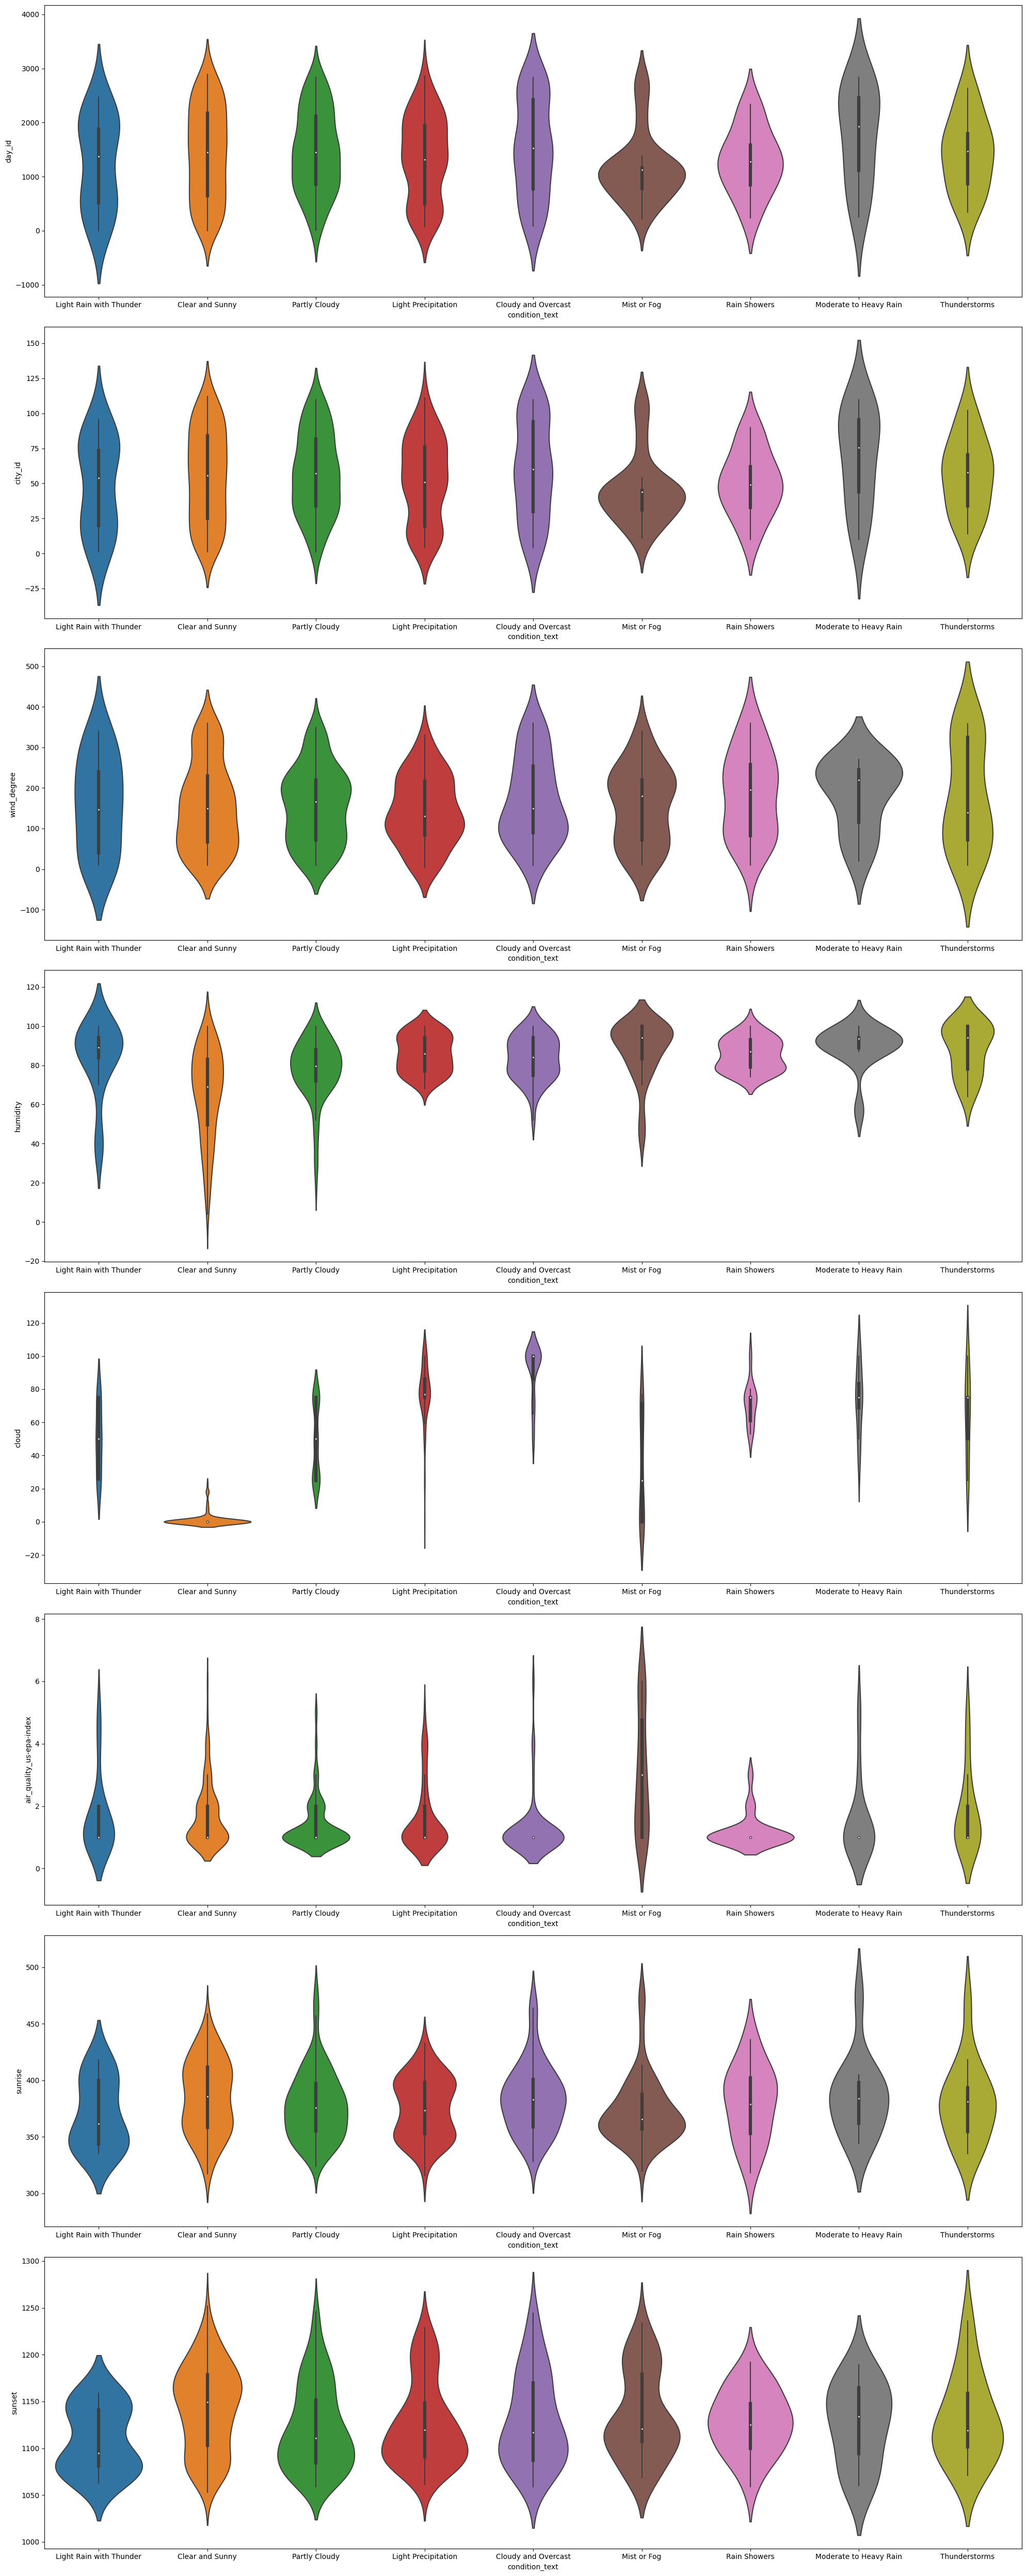

In [369]:
plt.figure(figsize=(20, 50))
for i, col in enumerate(categorical_features):
    plt.subplot(8, 1, i+1)
    sns.violinplot(data=df, x='condition_text', y=col)
plt.tight_layout()
plt.show()

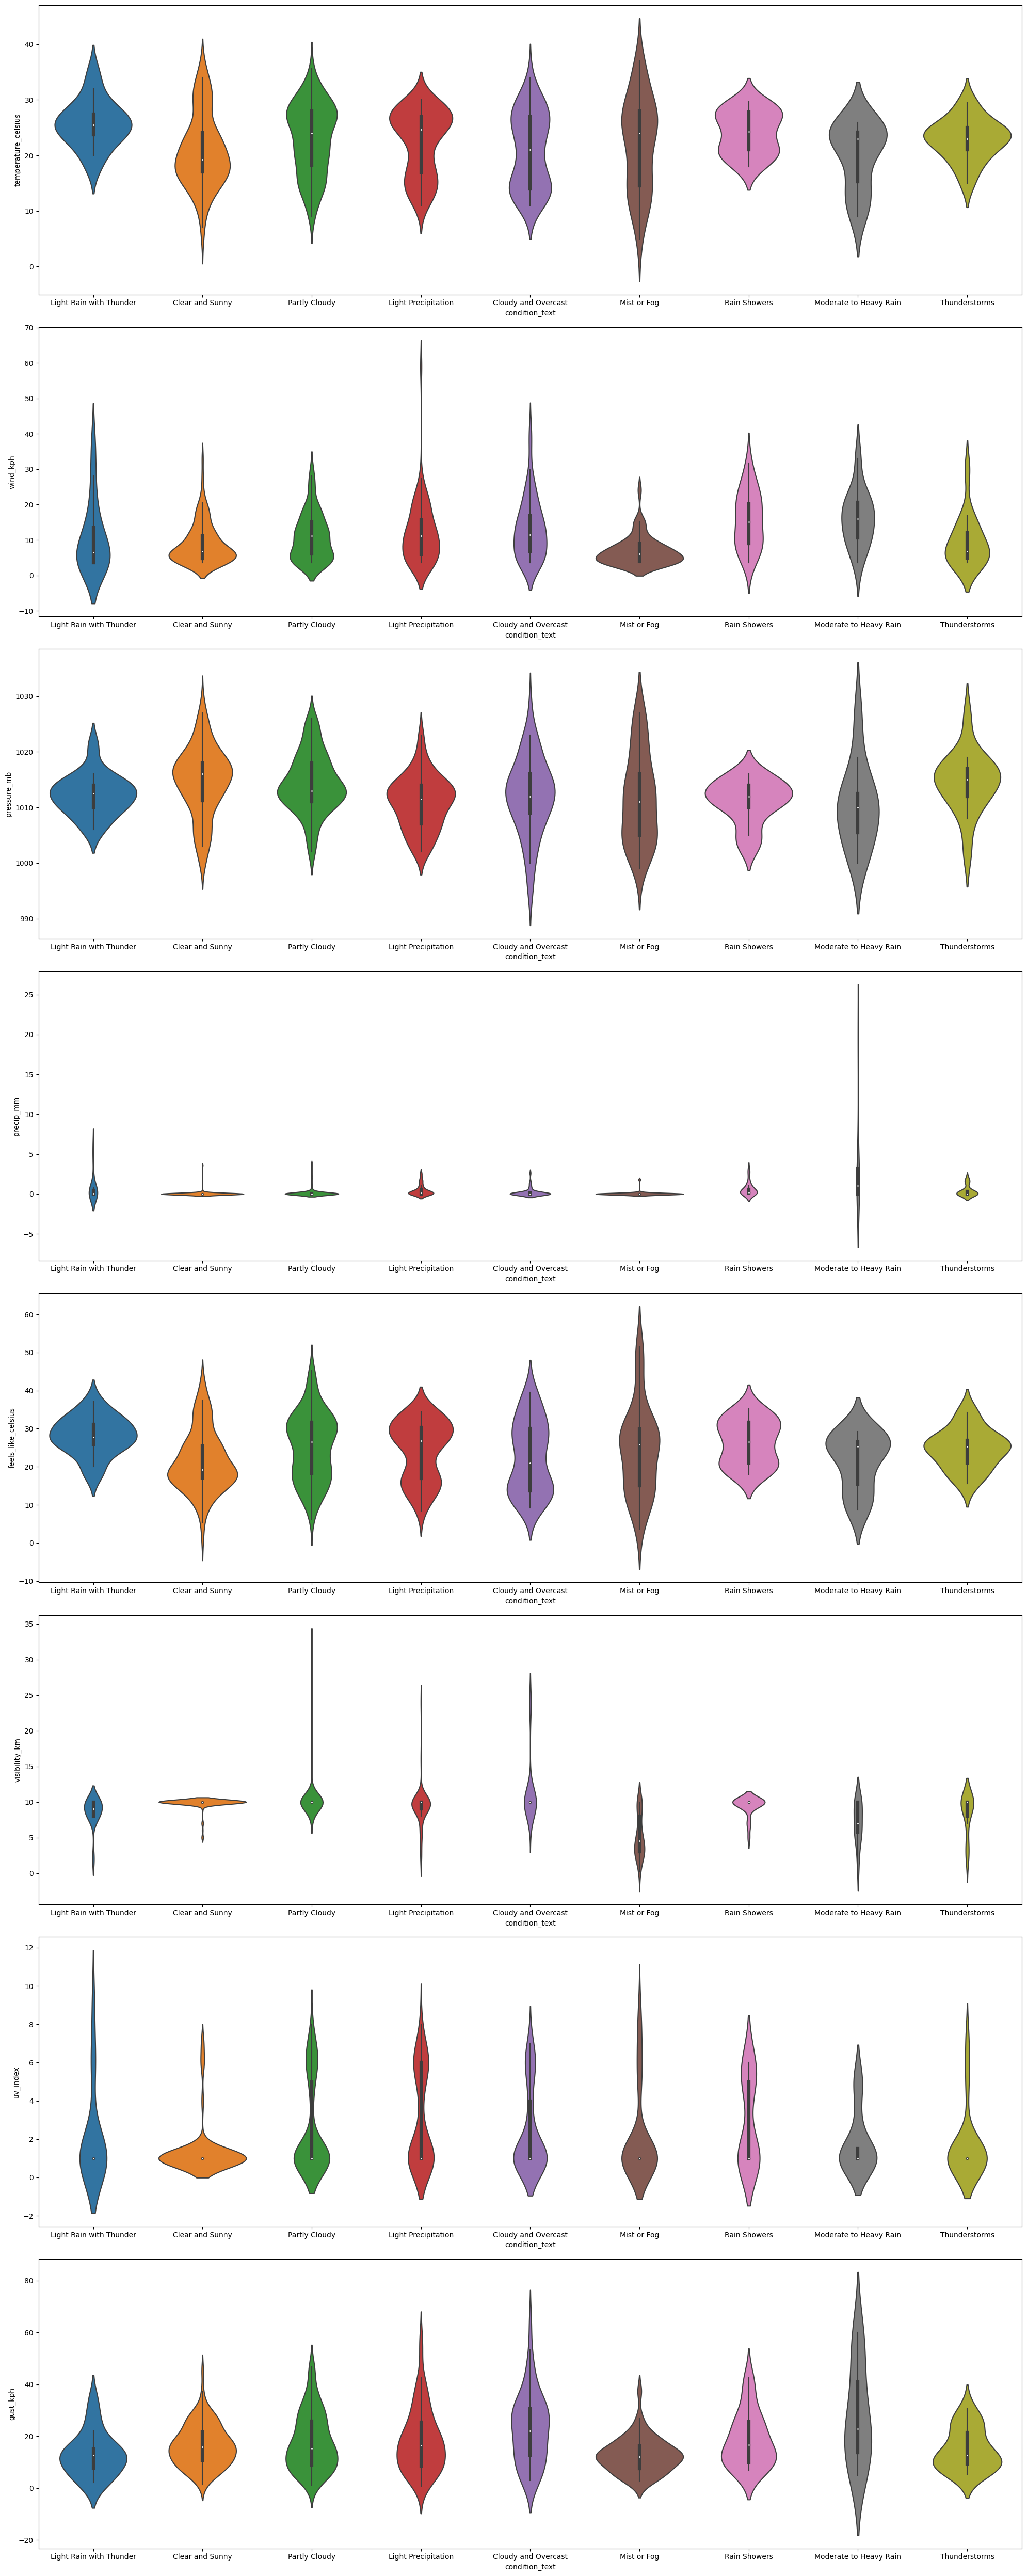

In [370]:
plt.figure(figsize=(20, 50))
for i, col in enumerate(continuous_features):
    plt.subplot(8, 1, i+1)
    sns.violinplot(data=df, x='condition_text', y=col)
plt.tight_layout()
plt.show()

In [587]:
# # Columns to exclude from scaling
# exclude_cols = ['day_id', 'city_id', 'condition_text']

# cols_to_scale = [col for col in df.columns if col not in exclude_cols]
# scaler = StandardScaler()
# df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
# df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [854]:
df['condition_text'] = df['condition_text'].replace('Clear and Sunny',0)
df['condition_text'] = df['condition_text'].replace('Partly Cloudy',1)
df['condition_text'] = df['condition_text'].replace('Light Precipitation',2)
df['condition_text'] = df['condition_text'].replace('Cloudy and Overcast',3)
df['condition_text'] = df['condition_text'].replace('Mist or Fog',4)
df['condition_text'] = df['condition_text'].replace('Rain Showers',5)
df['condition_text'] = df['condition_text'].replace('Light Rain with Thunder',6)
df['condition_text'] = df['condition_text'].replace('Thunderstorms',7)
df['condition_text'] = df['condition_text'].replace('Moderate to Heavy Rain',8)

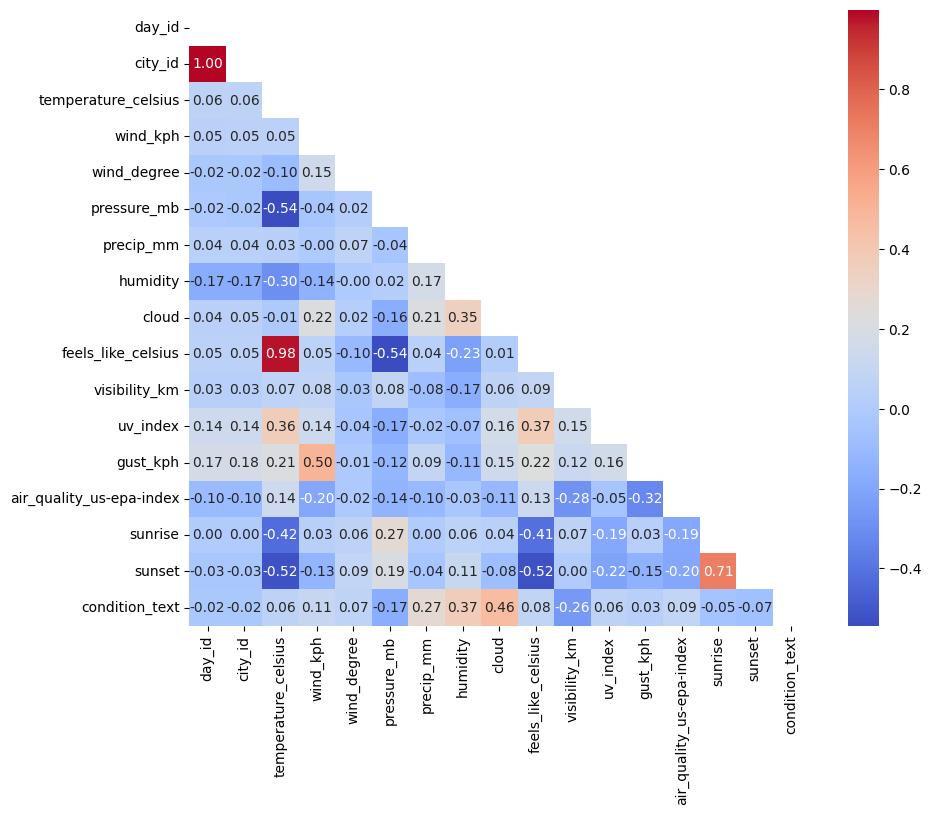

In [855]:
cor_mat = df.corr(method="pearson")

mask = np.triu(np.ones_like(cor_mat))

plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()

## Feature Engineering

In [856]:
df['temp_humidity_interaction'] = df['temperature_celsius'] - (0.4 * (1 - df['humidity'] / 100) * (df['temperature_celsius'] - 14))
df2['temp_humidity_interaction'] = df2['temperature_celsius'] - (0.4 * (1 - df2['humidity'] / 100) * (df2['temperature_celsius'] - 14))

In [857]:
df['Rain'] = df['cloud'] * 4 + (df['temperature_celsius'] - df['feels_like_celsius'] )* 3 + df['precip_mm'] * 4 - df['pressure_mb'] * 3 - df['visibility_km'] * 5 + df['air_quality_us-epa-index'] * 3 
df2['Rain'] = df2['cloud'] * 4 + (df2['temperature_celsius'] - df2['feels_like_celsius'] )* 3 + df2['precip_mm'] * 4 - df2['pressure_mb'] * 3 - df2['visibility_km'] * 5 + df2['air_quality_us-epa-index'] * 3 

In [858]:
df['Clear_Sky'] = df['visibility_km'] / ((df['uv_index'] *df['cloud'] * df['cloud'])+1)
df2['Clear_Sky'] = df2['visibility_km'] / ((df2['uv_index'] *df2['cloud'] * df2['cloud'])+1)

In [859]:
df['Not_Froggy'] = df['gust_kph'] * df['visibility_km'] *df['wind_kph'] 
df2['Not_Froggy'] = df2['gust_kph'] * df2['visibility_km'] *df2['wind_kph'] 

In [860]:
df['Stroming'] = (df['humidity'] * df['pressure_mb'] *df['Rain'])/(df['wind_degree'] * df['wind_kph'] *df['air_quality_us-epa-index'] *df['visibility_km'] *df['uv_index'] *df['gust_kph'] )
df2['Stroming'] = (df2['humidity'] * df2['pressure_mb'] *df2['Rain'])/(df2['wind_degree'] * df2['wind_kph'] *df2['air_quality_us-epa-index'] *df2['visibility_km'] *df2['uv_index'] *df2['gust_kph'] )

In [861]:
customDescription(df)

,type,count,nunique,null,mean,min,max
day_id,int64,479,479,0,1400.960334,3.000000,2889.000000
city_id,int64,479,110,0,54.526096,1.000000,112.000000
temperature_celsius,float64,479,81,0,22.098956,5.000000,37.000000
wind_kph,float64,479,56,0,10.748434,3.600000,59.000000
wind_degree,int64,479,134,0,158.440501,4.000000,360.000000
pressure_mb,float64,479,33,0,1013.108559,995.000000,1029.000000
precip_mm,float64,479,55,0,0.273695,0.000000,19.600000
humidity,int64,479,70,0,78.718163,4.000000,100.000000
cloud,int64,479,51,0,45.949896,0.000000,100.000000
feels_like_celsius,float64,479,191,0,23.801253,1.400000,51.500000


In [862]:
# Calculate MI scores
mi_scores_df = calculate_mi_scores(df, 'condition_text')

# Display MI scores
print("Mutual Information Scores:")
print(mi_scores_df)

Mutual Information Scores:
                      Feature  MI Score
0                   Clear_Sky  0.839029
1                        Rain  0.833540
2                       cloud  0.830684
3                     city_id  0.350918
4                      day_id  0.331300
5               visibility_km  0.219583
6                    humidity  0.175215
7                   precip_mm  0.166070
8         temperature_celsius  0.160394
9          feels_like_celsius  0.114746
10                pressure_mb  0.113831
11                 Not_Froggy  0.112058
12  temp_humidity_interaction  0.099425
13                    sunrise  0.091852
14                     sunset  0.082839
15                wind_degree  0.054685
16                   Stroming  0.053388
17   air_quality_us-epa-index  0.052603
18                   uv_index  0.018989
19                   wind_kph  0.016851
20                   gust_kph  0.000000


In [863]:
df = df.drop(columns=['gust_kph'], axis=1)
df2 = df2.drop(columns=['gust_kph'], axis=1)

In [864]:
df = df.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

In [865]:
df

,day_id,city_id,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,...,uv_index,air_quality_us-epa-index,sunrise,sunset,condition_text,temp_humidity_interaction,Rain,Clear_Sky,Not_Froggy,Stroming
0,3,1,20.0,3.6,10,1011.0,4.50,100,75,20.0,...,1.0,1,365,1158,6,20.0000,-2762.00,0.001777,453.6,-61560.449735
1,4,1,17.0,6.1,150,1018.0,0.00,88,0,17.0,...,1.0,1,366,1156,0,16.8560,-3101.00,10.000000,683.2,-2710.772678
2,7,1,21.0,4.0,310,1015.0,0.00,100,50,21.0,...,1.0,2,368,1151,1,21.0000,-2889.00,0.003998,604.0,-783.041818
3,19,1,19.0,3.6,64,1017.0,0.00,88,0,19.0,...,1.0,3,380,1131,0,18.7600,-3092.00,10.000000,298.8,-4823.488956
4,28,2,19.0,3.6,83,1010.0,0.00,73,25,19.0,...,1.0,1,377,1160,1,18.4600,-2977.00,0.015974,298.8,-8850.430235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2839,110,27.0,19.1,90,1014.0,0.01,70,25,29.8,...,6.0,1,339,1063,1,25.4400,-2997.36,0.002666,8709.6,-45.235868
475,2864,111,21.4,3.6,178,1012.0,0.00,89,75,21.4,...,6.0,1,377,1105,2,21.0744,-2783.00,0.000296,237.6,-987.793210
476,2874,112,16.9,16.6,68,1018.0,0.00,44,2,16.9,...,1.0,1,362,1069,0,16.2504,-3093.00,2.000000,4482.0,-454.568785
477,2887,112,19.5,5.4,27,1014.0,0.00,34,0,19.4,...,1.0,2,351,1071,0,18.0480,-3085.70,10.000000,604.8,-3257.354534


# Model Selection and Training

In [805]:
label = 'condition_text' 
X = df.drop(columns=[label], axis=1)  
y = df[label]

In [806]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size=0.1)

In [807]:
from sklearn.metrics import confusion_matrix, accuracy_score

#Function to plot the confusion matrix
def confusion_matrix(Actual, Predicted):
    labels = ['Clear and Sunny', 'Partly Cloudy', 'Light Precipitation','Cloudy and Overcast','Mist or Fog','Rain Showers','Light Rain with Thunder','Thunderstorms','Moderate to Heavy Rain']

    # Calculate the confusion matrix
    cm = confusion_matrix(Actual, Predicted)

    # Plot the confusion matrix
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    

In [808]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

#Function to evaluate the model
def print_score(model, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = model.predict(X_train)
        if(model == model_1):
            pred = tf.argmax(pred, axis=1)
        model_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{model_report}")
        print("_______________________________________________")
        
    elif train==False:
        pred = model.predict(X_test)
        if(model == model_1):
            pred = tf.argmax(pred, axis=1)
        model_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{model_report}")
        print("_______________________________________________")
        
        labels = ['Clear and Sunny', 'Partly Cloudy', 'Light Precipitation','Cloudy and Overcast','Mist or Fog','Rain Showers','Light Rain with Thunder','Thunderstorms','Moderate to Heavy Rain']
        # Calculate the confusion matrix
        cm = confusion_matrix(y_test, pred)
        # Plot the confusion matrix
        plt.figure(figsize=(12, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

## Model 1 - Gradient Boosting Classifier

In [809]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train, y_train], axis=1), label=label, task=tfdf.keras.Task.CLASSIFICATION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_test, y_test], axis=1), label=label, task=tfdf.keras.Task.CLASSIFICATION)

In [810]:
# Improved Model with Hyperparameter Tuning
model_1 = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    num_trees=500,       # Increased trees for potential improvement
    growing_strategy="BEST_FIRST_GLOBAL",  # Explore alternative growing strategies
    max_depth=25,        # Tune this based on your data complexity
    l1_regularization=0.01,   # Add regularization to prevent overfitting
    l2_regularization=0.01,
    min_examples=2,     # Tune this
    shrinkage=0.1,       # Learning rate
    subsample=0.8,     # Add subsampling for potential improvement
    categorical_algorithm="RANDOM",  # Consider "HISTOGRAM" as well
    random_seed=1023
)

model_1.compile(metrics=["accuracy"])

Use /tmp/tmp4jpxqpc1 as temporary training directory


[WARNING 24-06-24 08:55:08.2896 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-24 08:55:08.2897 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-24 08:55:08.2897 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [811]:
model_1.fit(x=train_ds, validation_data=test_ds)
evaluation = model_1.evaluate(test_ds, return_dict=True)

Reading training dataset...
Training dataset read in 0:00:00.382079. Found 431 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(48, shape=(), dtype=int32)
Validation dataset read in 0:00:00.377266. Found 48 examples.
Training model...
Model trained in 0:00:02.216180
Compiling model...


[INFO 24-06-24 08:55:11.3747 UTC kernel.cc:1233] Loading model from path /tmp/tmp4jpxqpc1/model/ with prefix 48930a69407b489d
[INFO 24-06-24 08:55:11.4221 UTC decision_forest.cc:660] Model loaded with 162 root(s), 9684 node(s), and 21 input feature(s).
[INFO 24-06-24 08:55:11.4222 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-06-24 08:55:11.4222 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 159ms/step - loss: 0.0000e+00 - accuracy: 0.8125


1/1 [==============================] - 0s 93ms/step
Test Result:
Accuracy Score: 81.25%
_______________________________________________
CLASSIFICATION REPORT:
              0          1    2         3         4    5    6    7    8  \
precision   1.0   0.700000  0.5  1.000000  1.000000  0.0  0.0  1.0  0.0   
recall      1.0   0.875000  0.5  0.500000  0.875000  0.0  0.0  1.0  0.0   
f1-score    1.0   0.777778  0.5  0.666667  0.933333  0.0  0.0  1.0  0.0   
support    15.0  16.000000  2.0  2.000000  8.000000  1.0  2.0  1.0  1.0   

           accuracy  macro avg  weighted avg  
precision    0.8125   0.577778      0.795833  
recall       0.8125   0.527778      0.812500  
f1-score     0.8125   0.541975      0.796759  
support      0.8125  48.000000     48.000000  
_______________________________________________


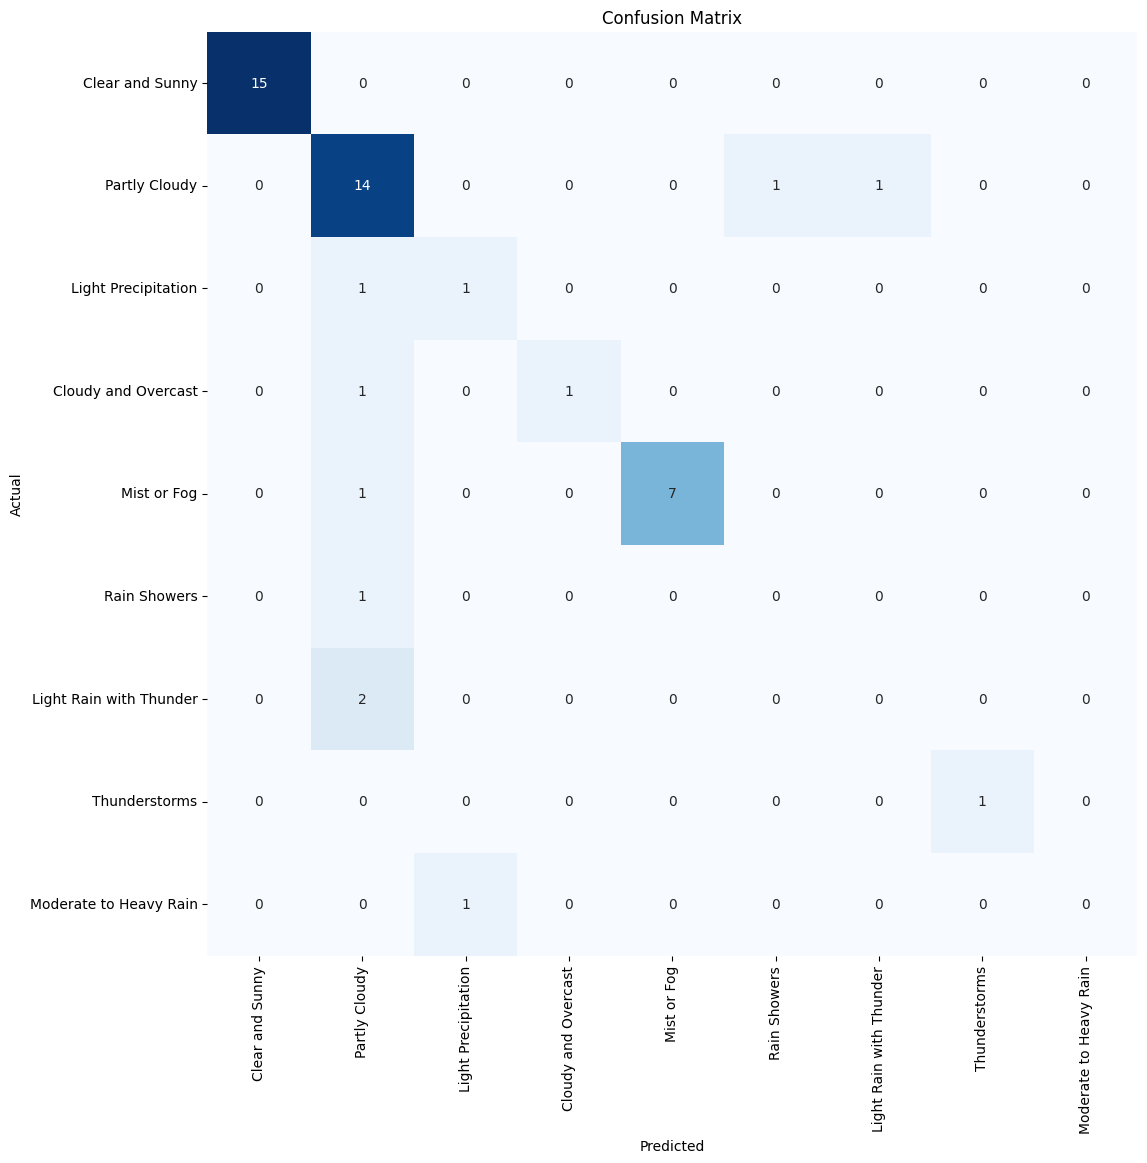

1/1 [==============================] - 0s 87ms/step
Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1     2     3     4     5     6     7     8  accuracy  \
precision    1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0       1.0   
recall       1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0       1.0   
f1-score     1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0       1.0   
support    107.0  106.0  66.0  51.0  42.0  20.0  14.0  14.0  11.0       1.0   

           macro avg  weighted avg  
precision        1.0           1.0  
recall           1.0           1.0  
f1-score         1.0           1.0  
support        431.0         431.0  
_______________________________________________


In [812]:
print_score(model_1, train_ds, y_train, test_ds, y_test, train=False)
print_score(model_1, train_ds, y_train, test_ds, y_test, train=True)

## Model 2 - Support Vector Machine

In [ ]:
model_2 = SVC(kernel='linear', gamma=1, C=0.1)
model_2.fit(X_train, y_train)

Test Result:
Accuracy Score: 58.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1         2    3         4    5    6    7    8  \
precision   0.923077   0.500000  0.166667  0.0  1.000000  0.0  0.0  0.0  0.0   
recall      0.800000   0.625000  0.500000  0.0  0.625000  0.0  0.0  0.0  0.0   
f1-score    0.857143   0.555556  0.250000  0.0  0.769231  0.0  0.0  0.0  0.0   
support    15.000000  16.000000  2.000000  2.0  8.000000  1.0  2.0  1.0  1.0   

           accuracy  macro avg  weighted avg  
precision  0.583333   0.287749      0.628739  
recall     0.583333   0.283333      0.583333  
f1-score   0.583333   0.270214      0.591664  
support    0.583333  48.000000     48.000000  
_______________________________________________


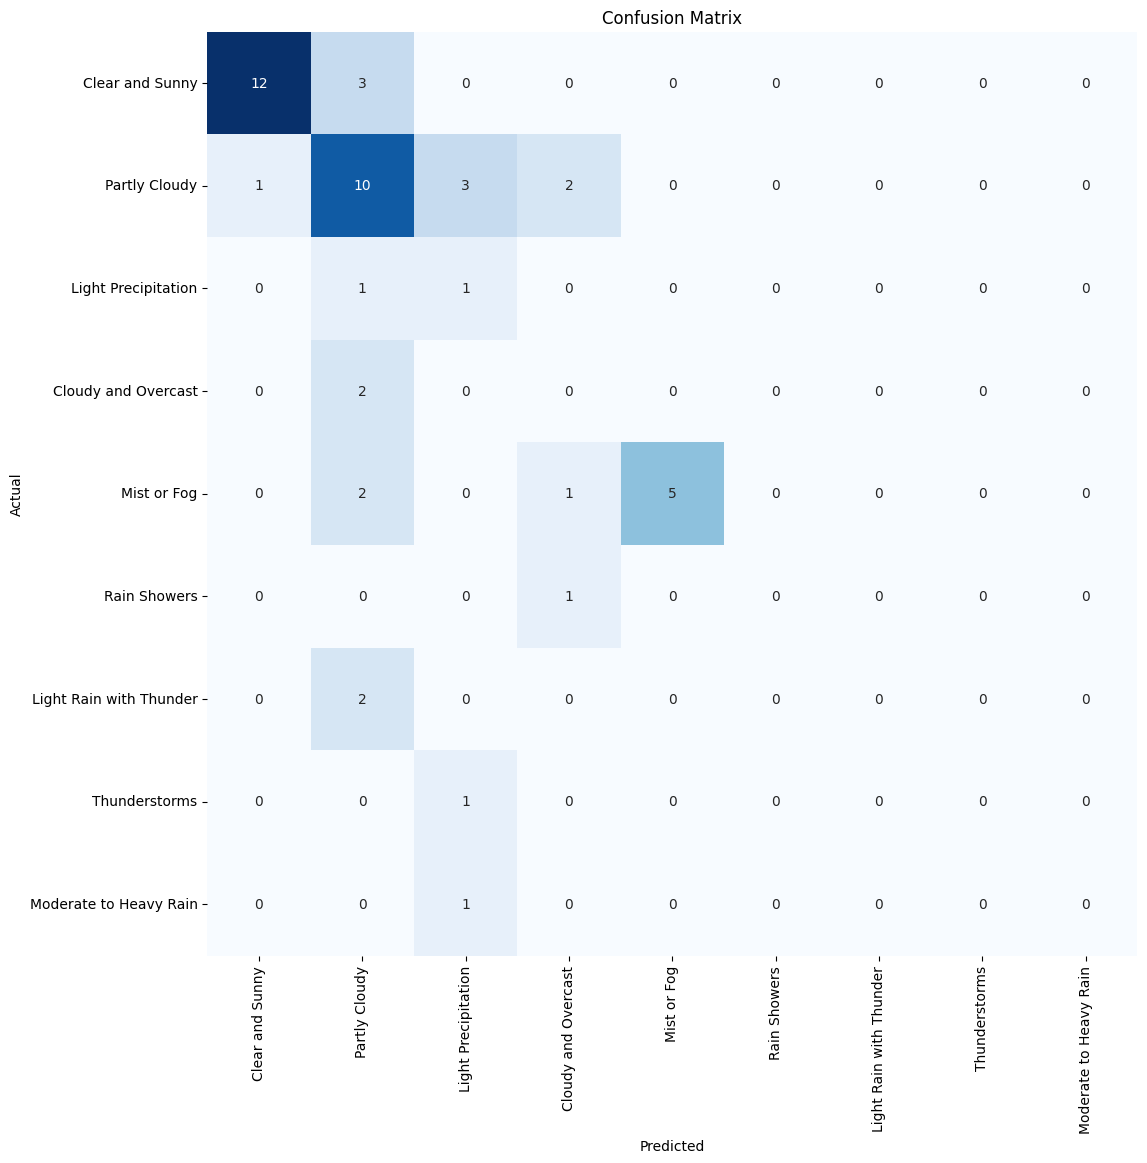

Train Result:
Accuracy Score: 65.43%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1          2          3          4     5  \
precision    0.788618    0.577465   0.494624   0.717949   0.931034   0.0   
recall       0.906542    0.773585   0.696970   0.549020   0.642857   0.0   
f1-score     0.843478    0.661290   0.578616   0.622222   0.760563   0.0   
support    107.000000  106.000000  66.000000  51.000000  42.000000  20.0   

              6     7          8  accuracy   macro avg  weighted avg  
precision   0.0   0.0   1.000000  0.654292    0.501077      0.614750  
recall      0.0   0.0   0.181818  0.654292    0.416755      0.654292  
f1-score    0.0   0.0   0.307692  0.654292    0.419318      0.616240  
support    14.0  14.0  11.000000  0.654292  431.000000    431.000000  
_______________________________________________


In [493]:
print_score(model_2, X_train, y_train, X_test, y_test, train=False)
print_score(model_2, X_train, y_train, X_test, y_test, train=True)

## Model 3 - XGB Classifier

In [494]:
from xgboost import XGBClassifier
model_3 = XGBClassifier(random_state=5, use_label_encoder=True, n_estimators=128)
model_3.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=128, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Test Result:
Accuracy Score: 75.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1         2         3         4    5    6    7  \
precision   1.000000   0.684211  0.200000  1.000000  0.857143  1.0  0.0  0.0   
recall      0.933333   0.812500  0.500000  0.500000  0.750000  1.0  0.0  0.0   
f1-score    0.965517   0.742857  0.285714  0.666667  0.800000  1.0  0.0  0.0   
support    15.000000  16.000000  2.000000  2.000000  8.000000  1.0  2.0  1.0   

             8  accuracy  macro avg  weighted avg  
precision  0.0      0.75   0.526817      0.754261  
recall     0.0      0.75   0.499537      0.750000  
f1-score   0.0      0.75   0.495639      0.743192  
support    1.0      0.75  48.000000     48.000000  
_______________________________________________


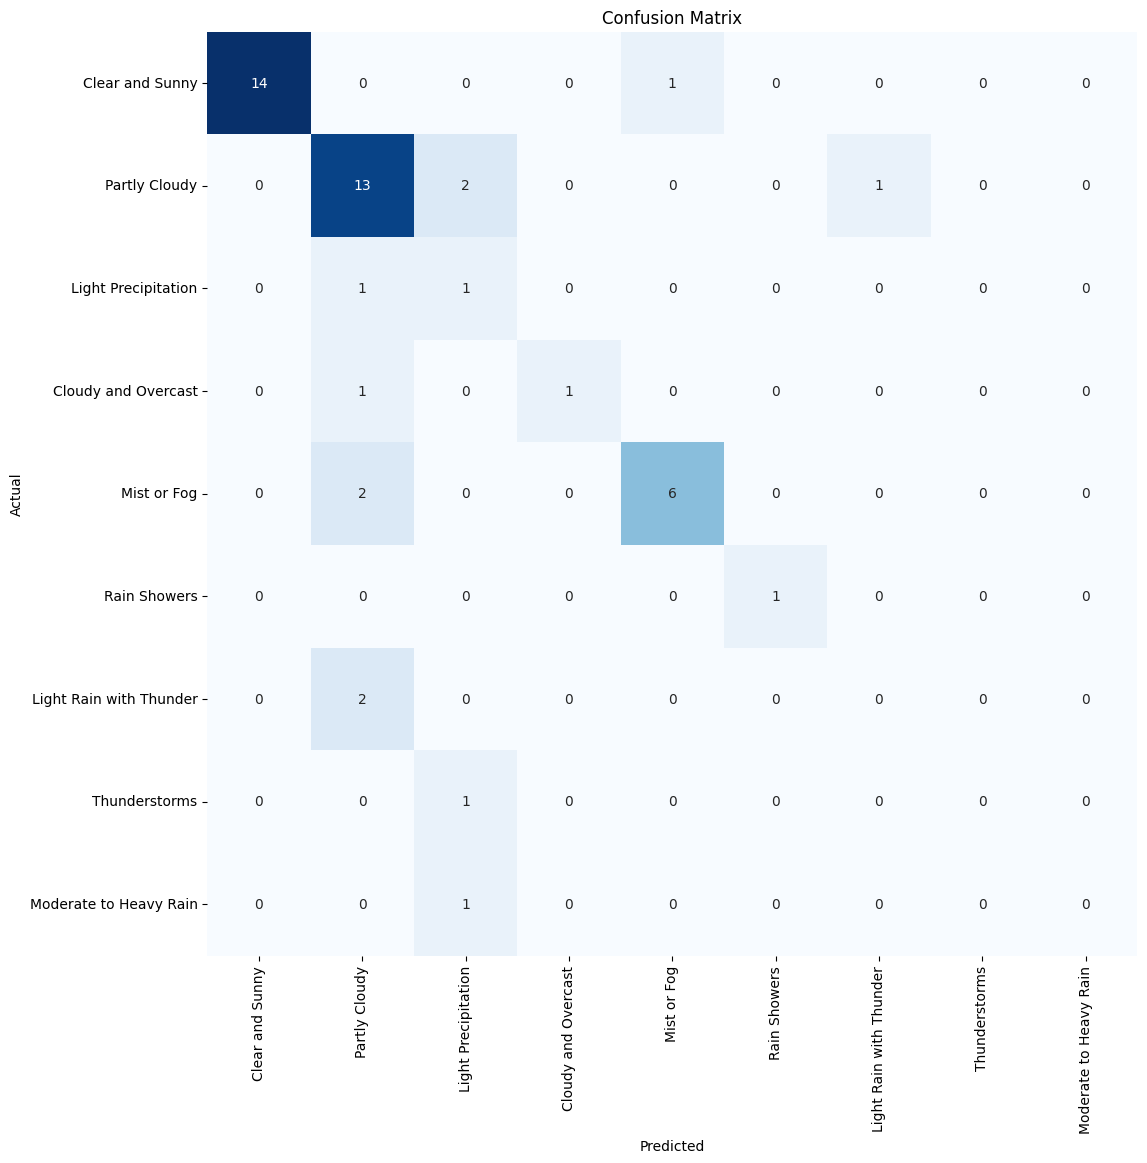

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1     2     3     4     5     6     7     8  accuracy  \
precision    1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0       1.0   
recall       1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0       1.0   
f1-score     1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0       1.0   
support    107.0  106.0  66.0  51.0  42.0  20.0  14.0  14.0  11.0       1.0   

           macro avg  weighted avg  
precision        1.0           1.0  
recall           1.0           1.0  
f1-score         1.0           1.0  
support        431.0         431.0  
_______________________________________________


In [495]:
print_score(model_3, X_train, y_train, X_test, y_test, train=False)
print_score(model_3, X_train, y_train, X_test, y_test, train=True)

## Model 4 - LGBM Classifier

In [496]:
import lightgbm as lgb

params = {'n_estimators': 8000, 
          'num_class': 9,
          'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'verbosity': -1,
          'random_state': 5, 
          'reg_alpha': 1.7878527151970849, 
          'reg_lambda': 1.391543710164331, 
          'colsample_bytree': 0.5, 
          'subsample': 0.5, 
          'learning_rate': 0.04, 
          'max_depth': 20, 
          'num_leaves': 70, 
          'min_child_samples': 40, 
          'min_data_per_groups': 16
         }

model_4 = lgb.LGBMClassifier(**params)
model_4.fit(X_train, y_train,eval_set=[(X_test, y_test)],callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)])

Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.777098
[200]	valid_0's multi_logloss: 0.740242
[300]	valid_0's multi_logloss: 0.73489
[400]	valid_0's multi_logloss: 0.732083
[500]	valid_0's multi_logloss: 0.73037
[600]	valid_0's multi_logloss: 0.72968
[700]	valid_0's multi_logloss: 0.729403
[800]	valid_0's multi_logloss: 0.72927
[900]	valid_0's multi_logloss: 0.729168
[1000]	valid_0's multi_logloss: 0.729102
[1100]	valid_0's multi_logloss: 0.72906
[1200]	valid_0's multi_logloss: 0.729036
[1300]	valid_0's multi_logloss: 0.72902
[1400]	valid_0's multi_logloss: 0.729009
[1500]	valid_0's multi_logloss: 0.729001
[1600]	valid_0's multi_logloss: 0.728997
[1700]	valid_0's multi_logloss: 0.728994
[1800]	valid_0's multi_logloss: 0.728992
[1900]	valid_0's multi_logloss: 0.728991
[2000]	valid_0's multi_logloss: 0.72899
[2100]	valid_0's multi_logloss: 0.728989
[2200]	valid_0's multi_logloss: 0.728989
[2300]	valid_0's multi_logloss: 0.728989
[2400]	valid

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.04, max_depth=20,
               metric='multi_logloss', min_child_samples=40,
               min_data_per_groups=16, n_estimators=8000, num_class=9,
               num_leaves=70, objective='multiclass', random_state=5,
               reg_alpha=1.7878527151970849, reg_lambda=1.391543710164331,
               subsample=0.5, verbosity=-1)

Test Result:
Accuracy Score: 79.17%
_______________________________________________
CLASSIFICATION REPORT:
              0          1         2         3         4    5    6    7    8  \
precision   1.0   0.722222  0.200000  1.000000  1.000000  1.0  0.0  0.0  0.0   
recall      1.0   0.812500  0.500000  0.500000  0.875000  1.0  0.0  0.0  0.0   
f1-score    1.0   0.764706  0.285714  0.666667  0.933333  1.0  0.0  0.0  0.0   
support    15.0  16.000000  2.000000  2.000000  8.000000  1.0  2.0  1.0  1.0   

           accuracy  macro avg  weighted avg  
precision  0.791667   0.546914      0.790741  
recall     0.791667   0.520833      0.791667  
f1-score   0.791667   0.516713      0.783473  
support    0.791667  48.000000     48.000000  
_______________________________________________


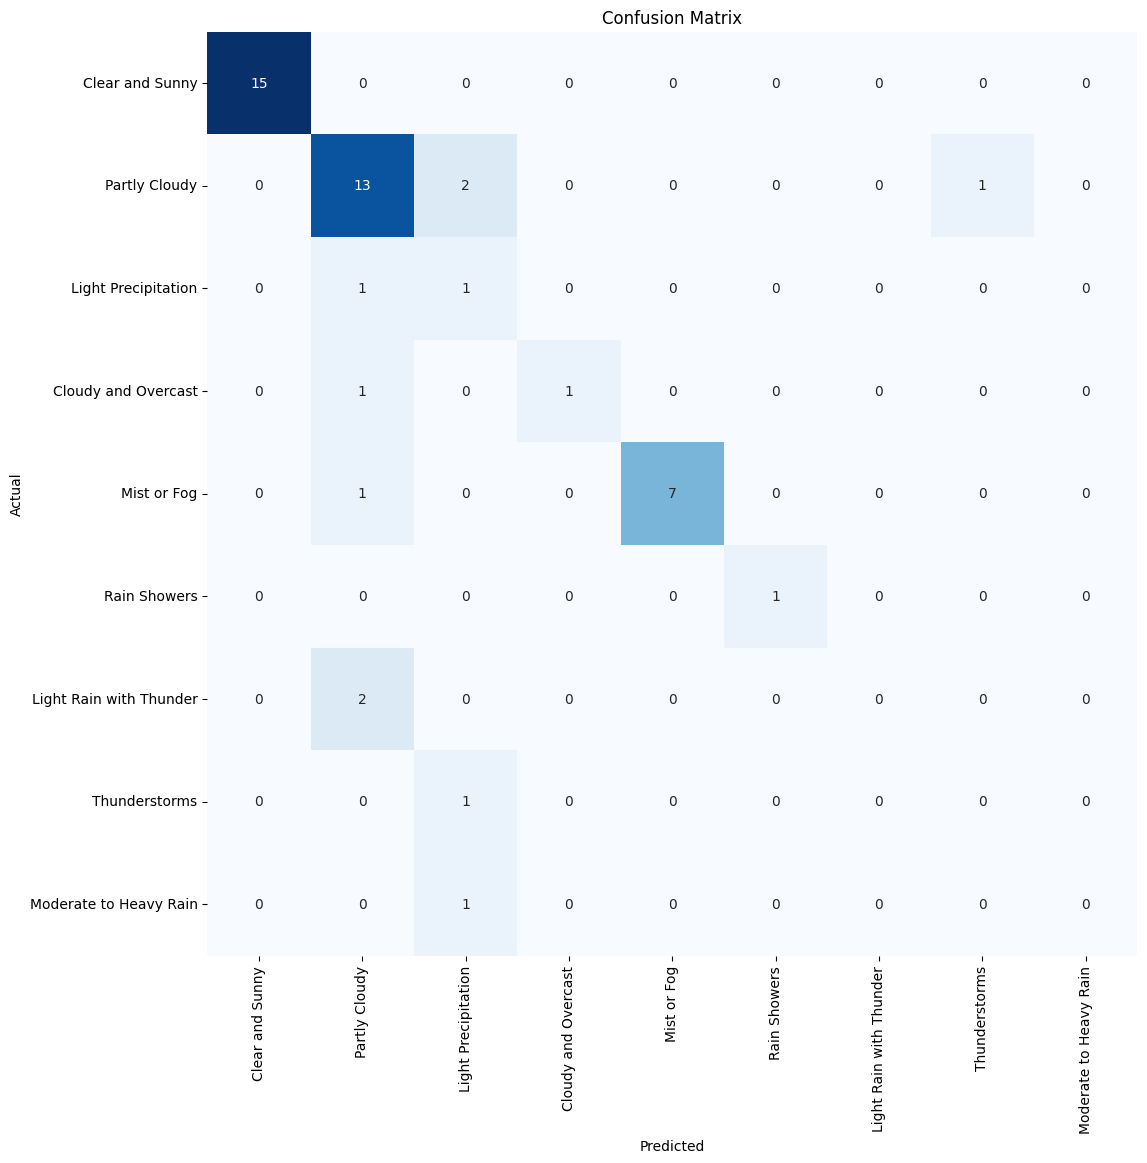

Train Result:
Accuracy Score: 95.59%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1          2          3          4          5  \
precision    0.946429    0.921739   0.984127   0.944444   1.000000   1.000000   
recall       0.990654    1.000000   0.939394   1.000000   0.857143   0.950000   
f1-score     0.968037    0.959276   0.961240   0.971429   0.923077   0.974359   
support    107.000000  106.000000  66.000000  51.000000  42.000000  20.000000   

                   6          7          8  accuracy   macro avg  weighted avg  
precision   1.000000   1.000000   1.000000  0.955916    0.977415      0.958448  
recall      0.857143   0.714286   0.909091  0.955916    0.913079      0.955916  
f1-score    0.923077   0.833333   0.952381  0.955916    0.940690      0.954919  
support    14.000000  14.000000  11.000000  0.955916  431.000000    431.000000  
_______________________________________________


In [497]:
print_score(model_4, X_train, y_train, X_test, y_test, train=False)
print_score(model_4, X_train, y_train, X_test, y_test, train=True)

# Predictions for the submission

In [813]:
df2

,day_id,city_id,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,...,uv_index,air_quality_us-epa-index,sunrise,sunset,temp_humidity_interaction,Rain,Clear_Sky,Not_Froggy,Stroming,most_frequent_condition_text_for_city
0,1,1,27.0,6.1,210,1006.0,0.0,54,75,28.0,...,6.0,2,364,1159,24.6080,-2765.0,0.000296,725.9,-82.112550,0.0
1,2,1,22.0,6.1,170,1006.0,0.0,73,75,24.5,...,1.0,1,365,1158,21.1360,-2772.5,0.001777,1427.4,-839.069204,0.0
2,5,1,18.0,3.6,92,1019.0,0.0,94,0,18.0,...,1.0,1,367,1155,17.9040,-3104.0,10.000000,324.0,-9974.494901,0.0
3,6,1,20.0,3.6,96,1019.0,0.0,88,0,20.0,...,1.0,1,367,1153,19.7120,-3104.0,10.000000,403.2,-7190.958995,0.0
4,8,1,21.0,20.2,330,1011.0,0.0,53,75,21.0,...,1.0,1,369,1150,19.6840,-2780.0,0.001777,3494.6,-129.169628,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,2888,112,19.5,16.6,113,1015.0,0.0,38,0,19.5,...,1.0,1,350,1071,18.1360,-3092.0,10.000000,4432.2,-238.117509,0.0
2410,2890,112,17.4,13.0,51,1017.0,0.0,49,0,17.4,...,1.0,1,349,1072,16.7064,-3098.0,10.000000,2886.0,-1048.894827,0.0
2411,2891,112,19.2,11.5,46,1016.0,0.0,34,0,19.2,...,1.0,2,348,1072,17.8272,-3092.0,10.000000,2449.5,-473.965619,0.0
2412,2892,112,19.2,14.4,76,1017.0,0.0,45,2,19.2,...,1.0,2,347,1072,18.0560,-3087.0,2.000000,3585.6,-259.217710,0.0


In [814]:
#Getting predictions from only 1st model
pred_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df2,task = tfdf.keras.Task.CLASSIFICATION)
predictions = model_1.predict(pred_ds)
predictions = tf.argmax(predictions, axis=1)

3/3 [==============================] - 0s 17ms/step


In [815]:
predictions

<tf.Tensor: shape=(2414,), dtype=int64, numpy=array([6, 1, 0, ..., 0, 0, 0])>

In [816]:
df2['condition_text'] = predictions

In [817]:
df2

,day_id,city_id,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,...,air_quality_us-epa-index,sunrise,sunset,temp_humidity_interaction,Rain,Clear_Sky,Not_Froggy,Stroming,most_frequent_condition_text_for_city,condition_text
0,1,1,27.0,6.1,210,1006.0,0.0,54,75,28.0,...,2,364,1159,24.6080,-2765.0,0.000296,725.9,-82.112550,0.0,6
1,2,1,22.0,6.1,170,1006.0,0.0,73,75,24.5,...,1,365,1158,21.1360,-2772.5,0.001777,1427.4,-839.069204,0.0,1
2,5,1,18.0,3.6,92,1019.0,0.0,94,0,18.0,...,1,367,1155,17.9040,-3104.0,10.000000,324.0,-9974.494901,0.0,0
3,6,1,20.0,3.6,96,1019.0,0.0,88,0,20.0,...,1,367,1153,19.7120,-3104.0,10.000000,403.2,-7190.958995,0.0,0
4,8,1,21.0,20.2,330,1011.0,0.0,53,75,21.0,...,1,369,1150,19.6840,-2780.0,0.001777,3494.6,-129.169628,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,2888,112,19.5,16.6,113,1015.0,0.0,38,0,19.5,...,1,350,1071,18.1360,-3092.0,10.000000,4432.2,-238.117509,0.0,0
2410,2890,112,17.4,13.0,51,1017.0,0.0,49,0,17.4,...,1,349,1072,16.7064,-3098.0,10.000000,2886.0,-1048.894827,0.0,0
2411,2891,112,19.2,11.5,46,1016.0,0.0,34,0,19.2,...,2,348,1072,17.8272,-3092.0,10.000000,2449.5,-473.965619,0.0,0
2412,2892,112,19.2,14.4,76,1017.0,0.0,45,2,19.2,...,2,347,1072,18.0560,-3087.0,2.000000,3585.6,-259.217710,0.0,0


In [818]:
df2['condition_text'] = df2['condition_text'].replace(0,'Clear and Sunny')
df2['condition_text'] = df2['condition_text'].replace(1,'Partly Cloudy')
df2['condition_text'] = df2['condition_text'].replace(2,'Light Precipitation')
df2['condition_text'] = df2['condition_text'].replace(3,'Cloudy and Overcast')
df2['condition_text'] = df2['condition_text'].replace(4,'Mist or Fog')
df2['condition_text'] = df2['condition_text'].replace(5,'Rain Showers')
df2['condition_text'] = df2['condition_text'].replace(6,'Light Rain with Thunder')
df2['condition_text'] = df2['condition_text'].replace(7,'Thunderstorms')
df2['condition_text'] = df2['condition_text'].replace(8,'Moderate to Heavy Rain')

In [819]:
df2['condition_text'].value_counts()

condition_text
Clear and Sunny            1069
Partly Cloudy               965
Light Precipitation         134
Mist or Fog                  69
Cloudy and Overcast          62
Light Rain with Thunder      39
Thunderstorms                31
Rain Showers                 26
Moderate to Heavy Rain       19
Name: count, dtype: int64

In [820]:
file_path = "/kaggle/input/predicta-1-0-predict-the-unpredictable-part-2/daily_data.csv" 
df3 = pd.read_csv(file_path)

In [821]:
df3 = df3[['day_id', 'city_id', 'condition_text']]
df2 = df2[['day_id', 'city_id', 'condition_text']]

In [822]:
df2

,day_id,city_id,condition_text
0,1,1,Light Rain with Thunder
1,2,1,Partly Cloudy
2,5,1,Clear and Sunny
3,6,1,Clear and Sunny
4,8,1,Partly Cloudy
...,...,...,...
2409,2888,112,Clear and Sunny
2410,2890,112,Clear and Sunny
2411,2891,112,Clear and Sunny
2412,2892,112,Clear and Sunny


In [823]:
df3

,day_id,city_id,condition_text
0,D0001,C001,NaN
1,D0002,C001,NaN
2,D0003,C001,Light Rain with Thunder
3,D0004,C001,Clear and Sunny
4,D0005,C001,NaN
...,...,...,...
2888,D2889,C112,Clear and Sunny
2889,D2890,C112,NaN
2890,D2891,C112,NaN
2891,D2892,C112,NaN


In [824]:
# Remove 'D' from `day_id` and 'C' from `city_id`
df3['day_id'] = df3['day_id'].astype(str).str.replace('D', '', regex=False)
df3['city_id'] = df3['city_id'].astype(str).str.replace('C', '', regex=False)

# Convert `day_id` and `city_id` to integers
df3['day_id'] = pd.to_numeric(df3['day_id'])
df3['city_id'] = pd.to_numeric(df3['city_id'])

In [825]:
df3 = df3.merge(df2[['day_id', 'city_id', 'condition_text']], on=['day_id', 'city_id'], how='left')

In [826]:
df3

,day_id,city_id,condition_text_x,condition_text_y
0,1,1,NaN,Light Rain with Thunder
1,2,1,NaN,Partly Cloudy
2,3,1,Light Rain with Thunder,NaN
3,4,1,Clear and Sunny,NaN
4,5,1,NaN,Clear and Sunny
...,...,...,...,...
2888,2889,112,Clear and Sunny,NaN
2889,2890,112,NaN,Clear and Sunny
2890,2891,112,NaN,Clear and Sunny
2891,2892,112,NaN,Clear and Sunny


In [827]:
# Create the new column 'condition_text'
df3['condition_text'] = df3['condition_text_x'].combine_first(df3['condition_text_y'])

# Optionally, you can drop the old columns if they are no longer needed
df3 = df3.drop(columns=['condition_text_x', 'condition_text_y'])

In [828]:
df3

,day_id,city_id,condition_text
0,1,1,Light Rain with Thunder
1,2,1,Partly Cloudy
2,3,1,Light Rain with Thunder
3,4,1,Clear and Sunny
4,5,1,Clear and Sunny
...,...,...,...
2888,2889,112,Clear and Sunny
2889,2890,112,Clear and Sunny
2890,2891,112,Clear and Sunny
2891,2892,112,Clear and Sunny


In [829]:
df3['condition_text'].value_counts()

condition_text
Clear and Sunny            1191
Partly Cloudy              1087
Light Precipitation         202
Mist or Fog                 119
Cloudy and Overcast         115
Light Rain with Thunder      55
Rain Showers                 47
Thunderstorms                46
Moderate to Heavy Rain       31
Name: count, dtype: int64

In [830]:
file_path = "/kaggle/input/predicta-1-0-predict-the-unpredictable-part-2/submission.csv" 
df4 = pd.read_csv(file_path)

In [831]:
df4['condition_text'] = df3['condition_text']

In [832]:
df4

,day_id,condition_text
0,D0001,Light Rain with Thunder
1,D0002,Partly Cloudy
2,D0003,Light Rain with Thunder
3,D0004,Clear and Sunny
4,D0005,Clear and Sunny
...,...,...
2888,D2889,Clear and Sunny
2889,D2890,Clear and Sunny
2890,D2891,Clear and Sunny
2891,D2892,Clear and Sunny


In [833]:
df4.to_csv("Submission.csv", index=False)